<a href="https://colab.research.google.com/github/cysaad/ai_study/blob/main/chadi_analysis_WTB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from shapely.geometry import Point
import matplotlib.pyplot as plt
import requests
import numpy as np


In [ ]:
import folium
from folium import plugins
from folium.plugins import HeatMap

In [ ]:
# Step 1: Retrieve Data from SEDS API
seds_url =  "https://eersc.usgs.gov/api/uswtdb/v1/turbines?&order=p_year.asc&t_cap=gt.0&select=case_id,t_manu,xlong,ylat,t_cap,t_ttlh,p_year,t_state"
response = requests.get(seds_url)
data = response.json()


In [ ]:
# Step 2: Convert to DataFrame
# Adjust the following line according to the actual structure of the SEDS API response
#df = pd.DataFrame(data)
df=pd.json_normalize(data)
df

case_id                  t_manu      xlong      ylat  t_cap  t_ttlh  \
0      3078137                   Micon -118.37759  35.03793    108     NaN   
1      3078139                 Lolland -118.37814  35.03763     75     NaN   
2      3078138                 Lolland -118.37788  35.03780     75     NaN   
3      3073305                  Vestas -118.35442  35.03581     65     NaN   
4      3005500                  Vestas -116.67849  33.94339     65    30.4   
...        ...                     ...        ...       ...    ...     ...   
69812  3087203                    None  -66.13876  18.45867    250    41.8   
69813  3087206                    None  -66.13881  18.45928    250    41.8   
69814  3002127  Northern Power Systems -105.23179  39.91159    100    40.5   
69815  3002673            Westinghouse -105.22269  39.90899    600    59.0   
69816  3004706            Westinghouse -105.22329  39.90780    600    59.0   

       p_year t_state  
0      1982.0      CA  
1      1982.0      CA  
2      1982.0      CA  
3      1982.0      CA  
4      1983.0      CA  
...       ...     ...  
69812     NaN      PR  
69813     NaN      PR  
69814     NaN      CO  
69815     NaN      CO  
69816     NaN      CO  

[69817 rows x 8 columns]

In [ ]:
# prompt: clean up and explore df

# Check Data Types
df.dtypes




case_id      int64
t_manu      object
xlong      float64
ylat       float64
t_cap        int64
t_ttlh     float64
p_year     float64
t_state     object
dtype: object

In [ ]:
# Drop rows with missing values
df = df.dropna()
df




case_id  t_manu      xlong      ylat  t_cap  t_ttlh  p_year t_state
4      3005500  Vestas -116.67849  33.94339     65    30.4  1983.0      CA
5      3001023  Vestas -116.67459  33.94320     65    30.4  1983.0      CA
6      3005710  Vestas -116.67954  33.94332     65    30.4  1983.0      CA
7      3010508  Vestas -116.67629  33.94500     65    30.4  1983.0      CA
8      3006173  Vestas -116.67469  33.94339     65    30.4  1983.0      CA
...        ...     ...        ...       ...    ...     ...     ...     ...
69742  3127559  Vestas  -88.64366  40.37134   3600   173.0  2023.0      IL
69743  3127545  Vestas  -88.49130  40.32748   4300   180.0  2023.0      IL
69744  3127380  Vestas  -88.56343  40.36639   4300   180.0  2023.0      IL
69745  3127482  Vestas  -88.64236  40.32229   4300   180.0  2023.0      IL
69746  3127331  Vestas  -88.63554  40.36416   4300   180.0  2023.0      IL

[68991 rows x 8 columns]

In [ ]:
# Convert Longitude and Latitude to Float
df['xlong'] = df['xlong'].astype(float)
df['ylat'] = df['ylat'].astype(float)
df



<ipython-input-95-c4ce7e920b1d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-95-c4ce7e920b1d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



case_id  t_manu      xlong      ylat  t_cap  t_ttlh  p_year t_state
4      3005500  Vestas -116.67849  33.94339     65    30.4  1983.0      CA
5      3001023  Vestas -116.67459  33.94320     65    30.4  1983.0      CA
6      3005710  Vestas -116.67954  33.94332     65    30.4  1983.0      CA
7      3010508  Vestas -116.67629  33.94500     65    30.4  1983.0      CA
8      3006173  Vestas -116.67469  33.94339     65    30.4  1983.0      CA
...        ...     ...        ...       ...    ...     ...     ...     ...
69742  3127559  Vestas  -88.64366  40.37134   3600   173.0  2023.0      IL
69743  3127545  Vestas  -88.49130  40.32748   4300   180.0  2023.0      IL
69744  3127380  Vestas  -88.56343  40.36639   4300   180.0  2023.0      IL
69745  3127482  Vestas  -88.64236  40.32229   4300   180.0  2023.0      IL
69746  3127331  Vestas  -88.63554  40.36416   4300   180.0  2023.0      IL

[68991 rows x 8 columns]

In [ ]:
# Convert Turbine Capacity to Megawatts
df['t_cap'] = df['t_cap'].apply(lambda x: x / 1000)
df


<ipython-input-96-58e5c6bf45bf>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



case_id  t_manu      xlong      ylat  t_cap  t_ttlh  p_year t_state
4      3005500  Vestas -116.67849  33.94339  0.065    30.4  1983.0      CA
5      3001023  Vestas -116.67459  33.94320  0.065    30.4  1983.0      CA
6      3005710  Vestas -116.67954  33.94332  0.065    30.4  1983.0      CA
7      3010508  Vestas -116.67629  33.94500  0.065    30.4  1983.0      CA
8      3006173  Vestas -116.67469  33.94339  0.065    30.4  1983.0      CA
...        ...     ...        ...       ...    ...     ...     ...     ...
69742  3127559  Vestas  -88.64366  40.37134  3.600   173.0  2023.0      IL
69743  3127545  Vestas  -88.49130  40.32748  4.300   180.0  2023.0      IL
69744  3127380  Vestas  -88.56343  40.36639  4.300   180.0  2023.0      IL
69745  3127482  Vestas  -88.64236  40.32229  4.300   180.0  2023.0      IL
69746  3127331  Vestas  -88.63554  40.36416  4.300   180.0  2023.0      IL

[68991 rows x 8 columns]

In [ ]:
# Convert Tower Height to Meters
df['t_ttlh'] = df['t_ttlh'].apply(lambda x: x / 3.281)
df


<ipython-input-97-bdc24bea7ca5>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



case_id  t_manu      xlong      ylat  t_cap     t_ttlh  p_year t_state
4      3005500  Vestas -116.67849  33.94339  0.065   9.265468  1983.0      CA
5      3001023  Vestas -116.67459  33.94320  0.065   9.265468  1983.0      CA
6      3005710  Vestas -116.67954  33.94332  0.065   9.265468  1983.0      CA
7      3010508  Vestas -116.67629  33.94500  0.065   9.265468  1983.0      CA
8      3006173  Vestas -116.67469  33.94339  0.065   9.265468  1983.0      CA
...        ...     ...        ...       ...    ...        ...     ...     ...
69742  3127559  Vestas  -88.64366  40.37134  3.600  52.727827  2023.0      IL
69743  3127545  Vestas  -88.49130  40.32748  4.300  54.861323  2023.0      IL
69744  3127380  Vestas  -88.56343  40.36639  4.300  54.861323  2023.0      IL
69745  3127482  Vestas  -88.64236  40.32229  4.300  54.861323  2023.0      IL
69746  3127331  Vestas  -88.63554  40.36416  4.300  54.861323  2023.0      IL

[68991 rows x 8 columns]

In [ ]:
# Convert Year to Integer
df['p_year'] = df['p_year'].astype(int)
df

<ipython-input-98-9803fd3199fa>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



case_id  t_manu      xlong      ylat  t_cap     t_ttlh  p_year t_state
4      3005500  Vestas -116.67849  33.94339  0.065   9.265468    1983      CA
5      3001023  Vestas -116.67459  33.94320  0.065   9.265468    1983      CA
6      3005710  Vestas -116.67954  33.94332  0.065   9.265468    1983      CA
7      3010508  Vestas -116.67629  33.94500  0.065   9.265468    1983      CA
8      3006173  Vestas -116.67469  33.94339  0.065   9.265468    1983      CA
...        ...     ...        ...       ...    ...        ...     ...     ...
69742  3127559  Vestas  -88.64366  40.37134  3.600  52.727827    2023      IL
69743  3127545  Vestas  -88.49130  40.32748  4.300  54.861323    2023      IL
69744  3127380  Vestas  -88.56343  40.36639  4.300  54.861323    2023      IL
69745  3127482  Vestas  -88.64236  40.32229  4.300  54.861323    2023      IL
69746  3127331  Vestas  -88.63554  40.36416  4.300  54.861323    2023      IL

[68991 rows x 8 columns]

In [ ]:

# Print Shape of DataFrame
print(df.shape)

(68991, 8)


<ipython-input-100-aff7d51795e8>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



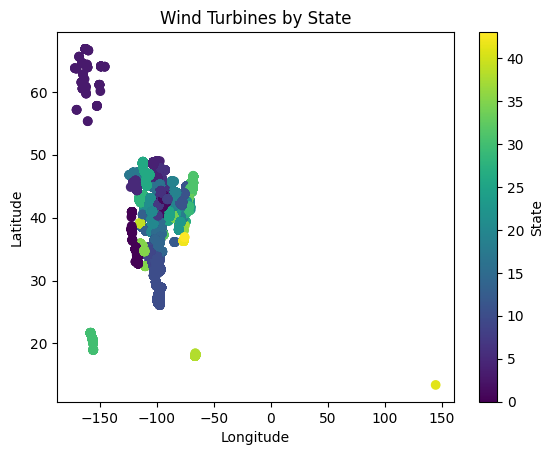

In [ ]:




# Create a mapping from state names to numbers
state_mapping = {state: idx for idx, state in enumerate(df['t_state'].unique())}

# Apply this mapping to create a numeric state column
df['state_numeric'] = df['t_state'].map(state_mapping)

# Create the scatter plot
plt.scatter(df['xlong'], df['ylat'], c=df['state_numeric'], cmap='viridis')
plt.colorbar(label='State')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Wind Turbines by State')
plt.show()


In [ ]:
# prompt: look up any invalide state name of data

df[df['t_state'].isin(df.keys()) == False]


case_id  t_manu      xlong      ylat  t_cap     t_ttlh  p_year t_state  \
4      3005500  Vestas -116.67849  33.94339  0.065   9.265468    1983      CA   
5      3001023  Vestas -116.67459  33.94320  0.065   9.265468    1983      CA   
6      3005710  Vestas -116.67954  33.94332  0.065   9.265468    1983      CA   
7      3010508  Vestas -116.67629  33.94500  0.065   9.265468    1983      CA   
8      3006173  Vestas -116.67469  33.94339  0.065   9.265468    1983      CA   
...        ...     ...        ...       ...    ...        ...     ...     ...   
69742  3127559  Vestas  -88.64366  40.37134  3.600  52.727827    2023      IL   
69743  3127545  Vestas  -88.49130  40.32748  4.300  54.861323    2023      IL   
69744  3127380  Vestas  -88.56343  40.36639  4.300  54.861323    2023      IL   
69745  3127482  Vestas  -88.64236  40.32229  4.300  54.861323    2023      IL   
69746  3127331  Vestas  -88.63554  40.36416  4.300  54.861323    2023      IL   

       state_numeric  
4                  0  
5                  0  
6                  0  
7                  0  
8                  0  
...              ...  
69742             25  
69743             25  
69744             25  
69745             25  
69746             25  

[68991 rows x 9 columns]

In [ ]:
!pip install folium


In [ ]:
import folium
from folium.plugins import HeatMap

In [ ]:
# Create a heatmap of turbine density
heat_map = HeatMap(df[['xlong', 'ylat']])
folium.Map(location=[39.5, -98.5], zoom_start=4).add_child(heat_map).save('heat_map.html')


In [ ]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

# ... your code to create 'heat_map' and 'map_obj' ...




# Assuming 'df' is your DataFrame and contains 'xlong' and 'ylat' columns for longitude and latitude

# Create the heatmap object
heat_map = HeatMap(df[['xlong', 'ylat']], radius=10)  # You can adjust the radius as needed

# Create a Folium map object
map_obj = folium.Map(location=[39.5, -98.5], zoom_start=4)

# Add the heatmap to the map object
map_obj.add_child(heat_map)

# Save the map to an HTML file
map_obj.save('heat_map.html')
# Display the map inline in the Colab notebook
display(map_obj)

In [ ]:
# Display heatmap in Colab
from IPython.display import HTML
HTML('<iframe src="heat_map.html" width="100%" height="500px"></iframe>')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning:

Consider using IPython.display.IFrame instead



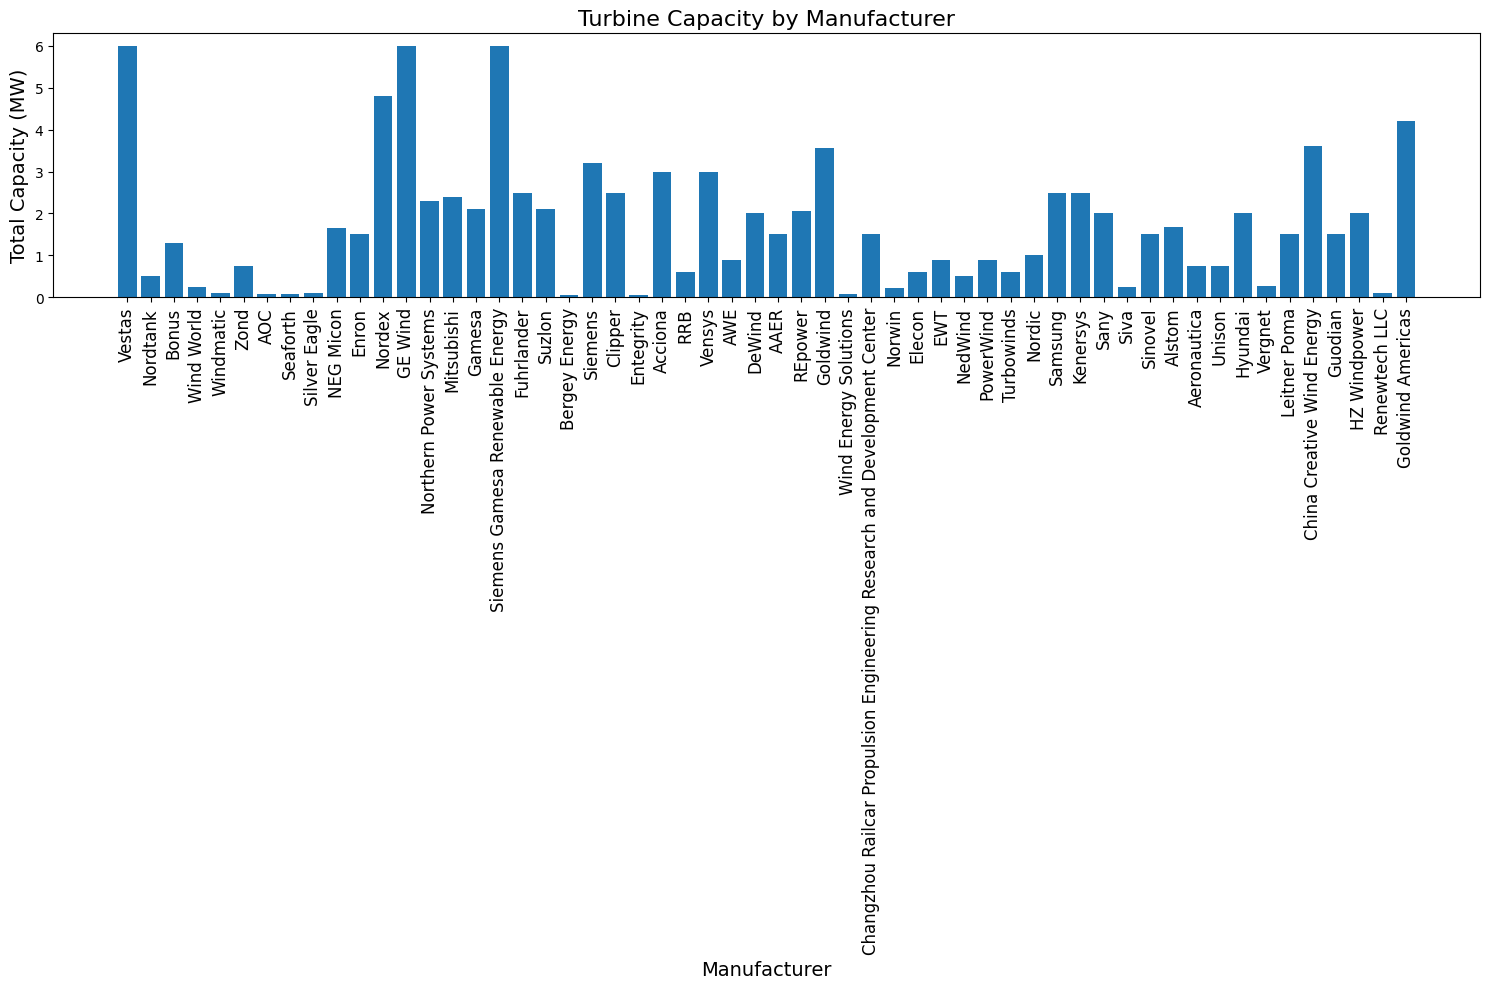

In [ ]:
import matplotlib.pyplot as plt

#

plt.figure(figsize=(15, 10))  # Increase figure size for clarity

# Plotting the bar chart
plt.bar(df['t_manu'], df['t_cap'])

# Rotating the x-axis labels to avoid overlap
plt.xticks(rotation=90)  # Rotate labels vertically

# Enlarging the label font size if necessary
plt.tick_params(axis='x', which='major', labelsize=12)

# Set titles and labels
plt.title('Turbine Capacity by Manufacturer', fontsize=16)
plt.xlabel('Manufacturer', fontsize=14)
plt.ylabel('Total Capacity (MW)', fontsize=14)

# Use tight_layout to fit the labels
plt.tight_layout()

# Show the plot
plt.show()


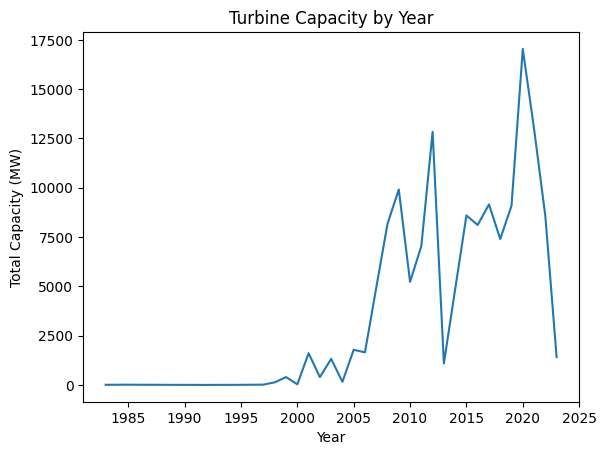

In [ ]:
# Create a line chart of turbine capacity by year
df.groupby('p_year')['t_cap'].sum().plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Total Capacity (MW)')
plt.title('Turbine Capacity by Year')
plt.show()

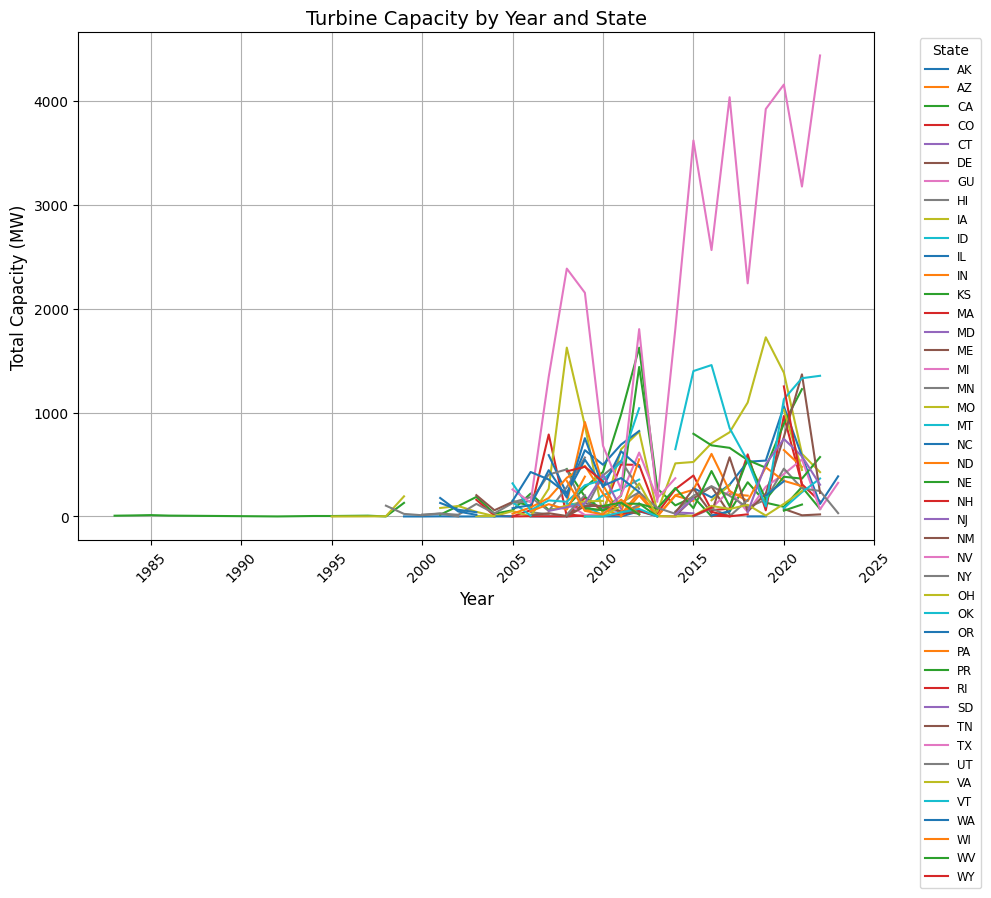

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and it includes 'p_year' for year, 't_state' for state, and 't_cap' for capacity
# df = pd.read_csv('your_data.csv')  # Replace with your actual data loading code

# Group by year and state, then sum the capacities
capacity_by_year_state = df.groupby(['p_year', 't_state'])['t_cap'].sum().unstack()

# Plot a line for each state
ax = capacity_by_year_state.plot(kind='line', figsize=(10, 8))

# Set the labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Capacity (MW)', fontsize=12)
ax.set_title('Turbine Capacity by Year and State', fontsize=14)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a title, outside of the plot to save space
ax.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Show grid lines
ax.grid(True)

# Use tight_layout to fit everything neatly
plt.tight_layout()

# Show the plot
plt.show()


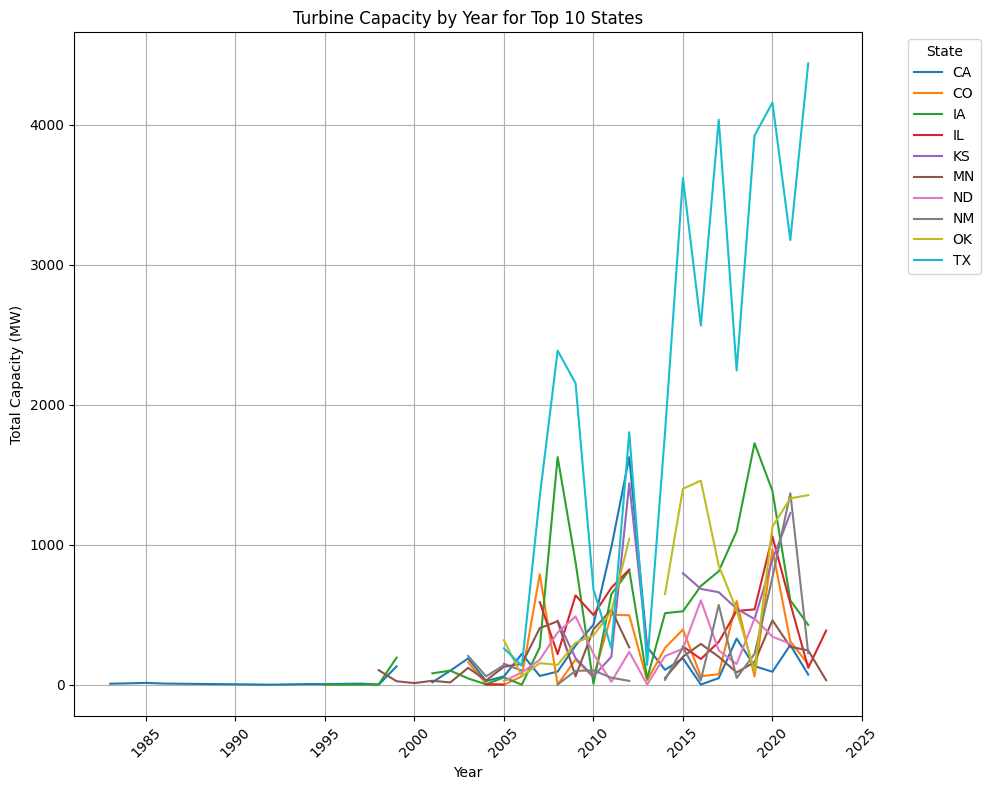

In [ ]:
import matplotlib.pyplot as plt

#

# Aggregate capacity by state and sort to find the top 10 states
top_states = df.groupby('t_state')['t_cap'].sum().sort_values(ascending=False).head(10).index

# Filter the original DataFrame to include only the top states
top_states_df = df[df['t_state'].isin(top_states)]

# Group by year and state, then sum capacities for top states
capacity_by_year_state = top_states_df.groupby(['p_year', 't_state'])['t_cap'].sum().unstack()

# Plot a line for each of the top states
ax = capacity_by_year_state.plot(kind='line', figsize=(10, 8))

# Set the labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Total Capacity (MW)')
ax.set_title('Turbine Capacity by Year for Top 10 States')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a title, placed outside of the plot
ax.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid lines
ax.grid(True)

# Use tight_layout to fit everything neatly
plt.tight_layout()

# Show the plot
plt.show()


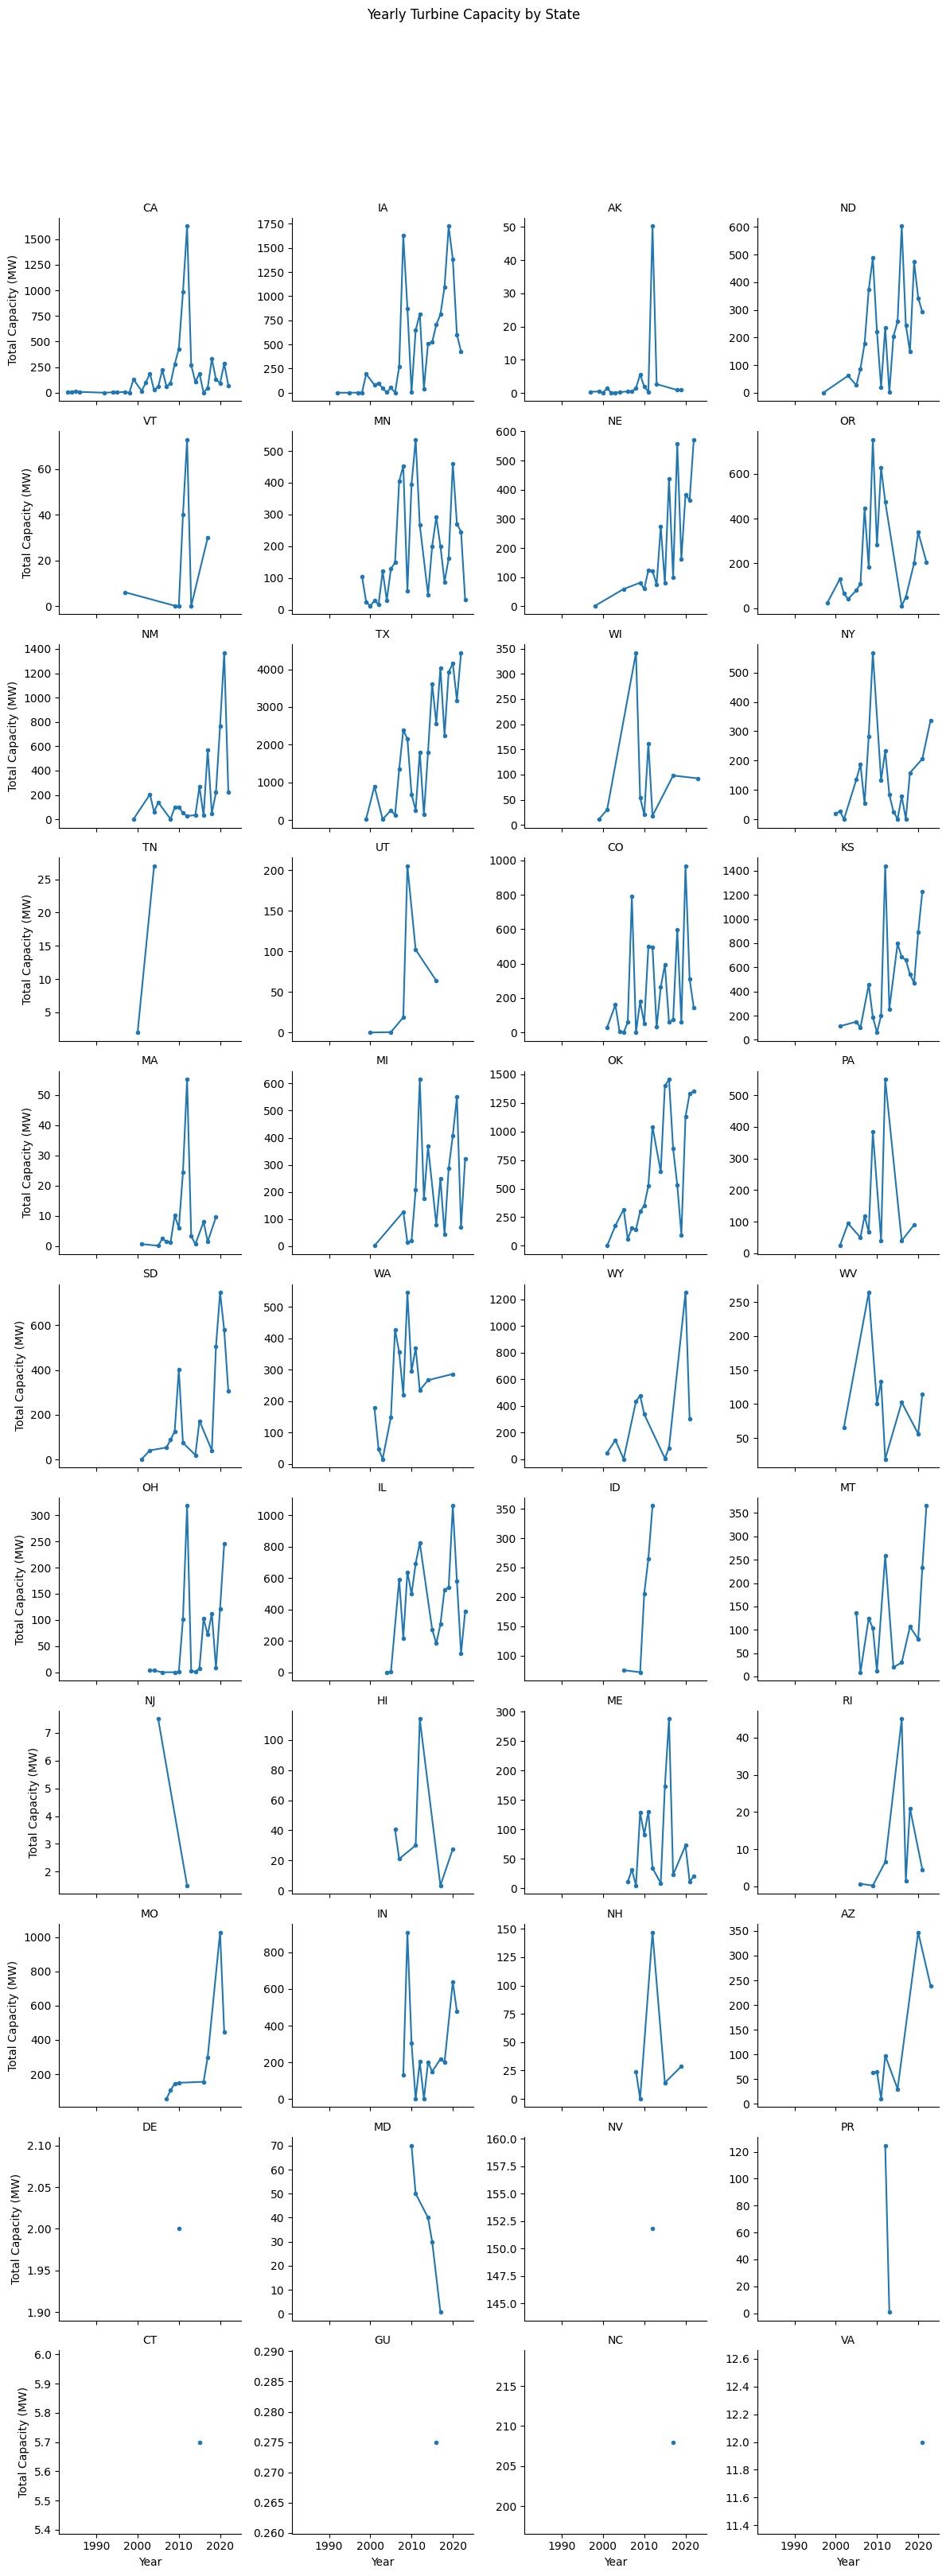

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame and it includes 'p_year', 't_state', and 't_cap' for year, state, and capacity, respectively.

# First, create a new DataFrame that aggregates capacity by year and state
capacity_by_year_state = df.groupby(['p_year', 't_state'])['t_cap'].sum().reset_index()

# Now, create a FacetGrid line chart using Seaborn
g = sns.FacetGrid(capacity_by_year_state, col="t_state", col_wrap=4, height=3, sharey=False)
g = g.map(plt.plot, "p_year", "t_cap", marker=".")

# Add titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Total Capacity (MW)")

# Add a main title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Yearly Turbine Capacity by State')

# Show the plot
plt.show()


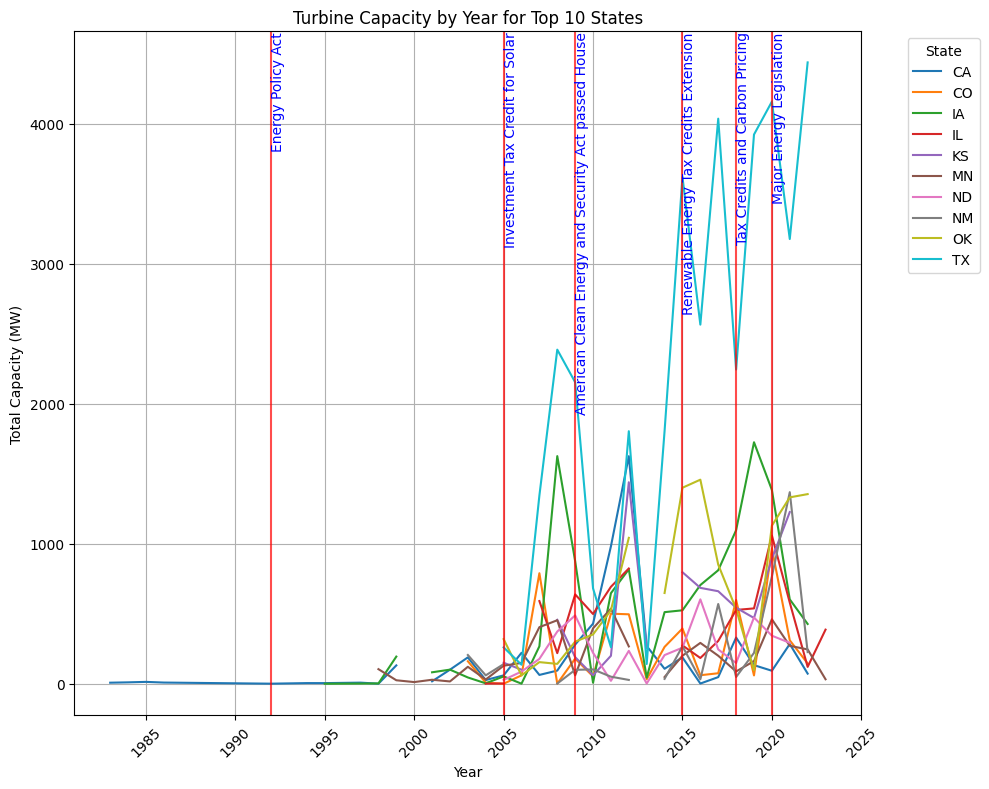

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Example policy events and their years
policy_events = {
    1992: 'Energy Policy Act',
    2005: 'Investment Tax Credit for Solar',
    2009: 'American Clean Energy and Security Act passed House',
    2015: 'Renewable Energy Tax Credits Extension',
    2018: 'Tax Credits and Carbon Pricing',
    2020: 'Major Energy Legislation'
}

# Your existing plotting code for the capacity by year
 #Aggregate capacity by state and sort to find the top 10 states
top_states = df.groupby('t_state')['t_cap'].sum().sort_values(ascending=False).head(10).index
# Filter the original DataFrame to include only the top states
top_states_df = df[df['t_state'].isin(top_states)]

# Group by year and state, then sum capacities for top states
capacity_by_year_state = top_states_df.groupby(['p_year', 't_state'])['t_cap'].sum().unstack()

# Plot a line for each of the top states
ax = capacity_by_year_state.plot(kind='line', figsize=(10, 8))

# Set the labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Total Capacity (MW)')
ax.set_title('Turbine Capacity by Year for Top 10 States')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend with a title, placed outside of the plot
ax.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid lines
ax.grid(True)

# Use tight_layout to fit everything neatly
plt.tight_layout()

# Add vertical lines and annotations for each policy event
for year, event in policy_events.items():
    plt.axvline(x=year, color='red', linestyle='solid', alpha=0.7)  # Adds a vertical line
    plt.text(year, plt.ylim()[1], event, rotation=90, verticalalignment='top',color='blue')  # Adds a text label

# Adjust the plot to make sure everything fits
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt



# Create the pie chart
plt.figure(figsize=(10, 8))
patches, texts, autotexts = plt.pie(
    df['t_cap'], labels=df['t_state'], autopct='%1.1f%%', startangle=140, explode=[0.1 if i == df['t_cap'].idxmax() else 0 for i in range(len(df))])

for autotext in autotexts:
    autotext.set_size('x-large')

# Make the labels clear
for text in texts:
    text.set_size('x-large')

# Add a legend
plt.legend(patches, df['t_state'], loc="best", fontsize='x-large')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Tight layout to use space effectively
plt.tight_layout(pad=0.5)

# Show the plot
plt.show()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7894e1bf68c0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7894e1bf5b40> (for post_execute):


KeyboardInterrupt: 

Text(0.5, 1.0, 'Number of Turbines Installed by Year')

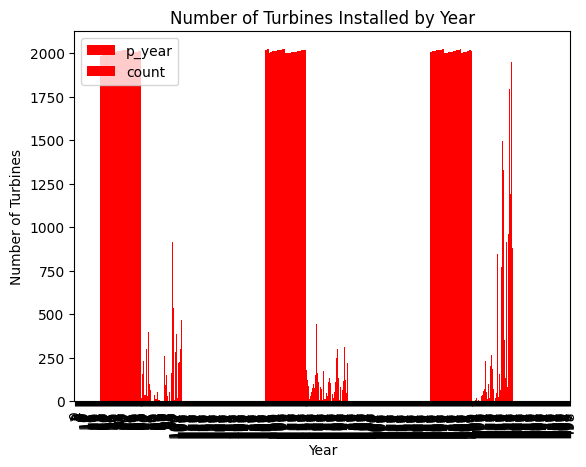

In [ ]:
# prompt:'Number of Turbines Installed by Year')
turbines_by_year_and_state = df.groupby(['t_state', 'p_year']).size().reset_index(name='count')
turbines_by_year_and_state.plot(kind='bar', color='red')
plt.xlabel('Year')
plt.ylabel('Number of Turbines')
plt.title('Number of Turbines Installed by Year')


Text(0.5, 1.0, 'Number of Turbines Installed by Year and State')

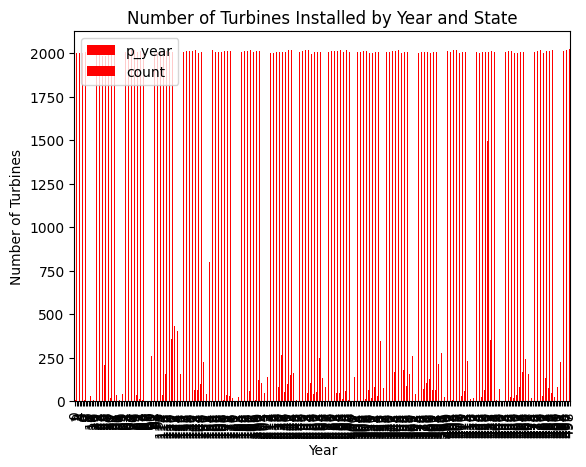

In [ ]:
turbines_by_year_and_state = df.groupby(['t_state', 'p_year']).size().reset_index(name='count')
turbines_by_year_and_state = turbines_by_year_and_state.groupby('t_state').head(10)
turbines_by_year_and_state.plot(kind='bar', color='red', legend=True)
plt.xlabel('Year')
plt.ylabel('Number of Turbines')
plt.title('Number of Turbines Installed by Year and State')

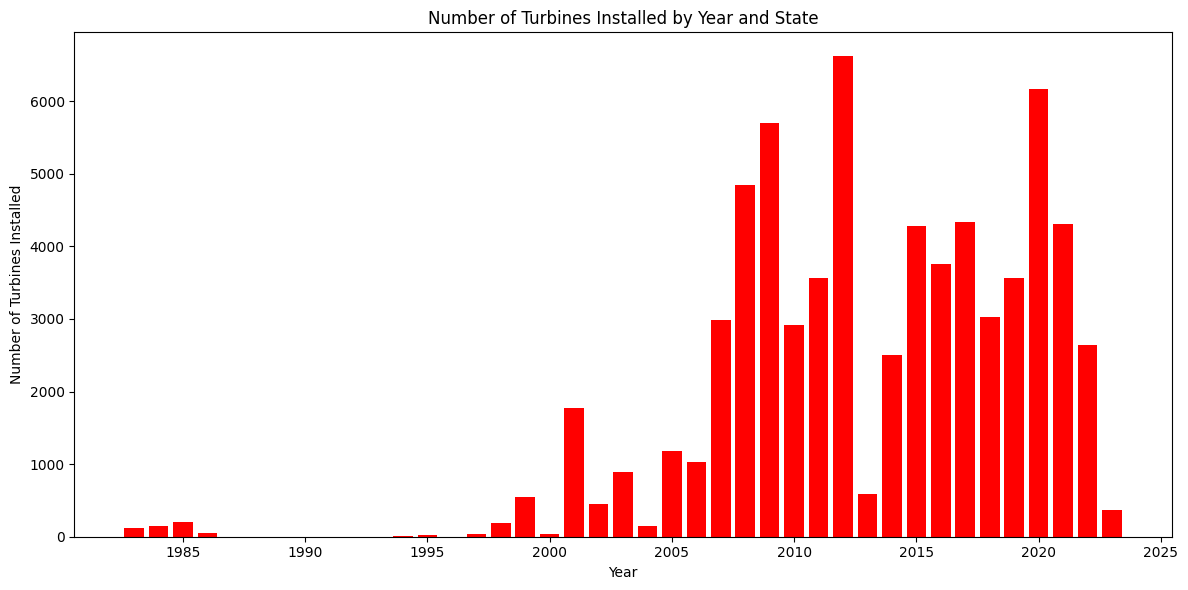

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


# Group the data by 'p_year' and get the count of installations
turbine_count_by_year = df.groupby('p_year')['t_cap'].count().reset_index(name='count')

# Create the bar chart
plt.figure(figsize=(12, 6))  # You can adjust the figure size to your preference
plt.bar(turbine_count_by_year['p_year'], turbine_count_by_year['count'], color='red')

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Number of Turbines Installed')
plt.title('Number of Turbines Installed by Year and State')

# Improve layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-38-dc3ca0586e8c>:31: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.

<ipython-input-38-dc3ca0586e8c>:49: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.



<Figure size 1800x1000 with 0 Axes>

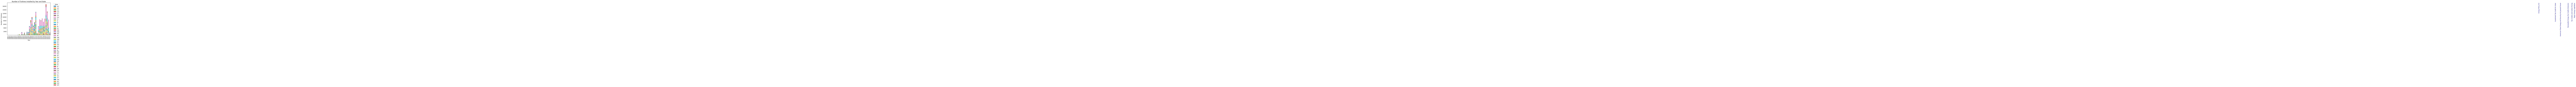

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd

# Example policy events and their years
policy_events = {
    1992: 'Energy Policy Act',
    2005: 'Investment Tax Credit for Solar',
    2009: 'American Clean Energy and Security Act passed House',
    2015: 'Renewable Energy Tax Credits Extension',
    2018: 'Tax Credits and Carbon Pricing',
    2020: 'Major Energy Legislation'
}


# Group and sum or count your data as needed
grouped_df = df.groupby(['p_year', 't_state'])['t_cap'].sum().unstack()

# Make the figure larger to accommodate the legend
plt.figure(figsize=(18, 10))  # Adjust the size as necessary

# Plot the data, setting the legend outside the plot
grouped_df.plot(kind='bar', stacked=True)
plt.title('Number of Turbines Installed by Year and State')
plt.xlabel('Year')
plt.ylabel('Number of Turbines')

# Place the legend outside the plot area
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right side to make space for the legend
# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Add a legend with a title, placed outside of the plot
ax.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid lines
ax.grid(True)

for year, event in policy_events.items():
    plt.axvline(x=year, color='red', linestyle='solid', alpha=0.7)  # Adds a vertical line
    plt.text(year, plt.ylim()[1], event, rotation=90, verticalalignment='top',color='blue')  # Adds a text label

# Add vertical lines and annotations for each policy event


# Adjust the plot to make sure everything fits
plt.tight_layout()


# Show the plot
plt.show()


ValueError: 'locs' must be 1D with shape (M,). Your input has shape ().

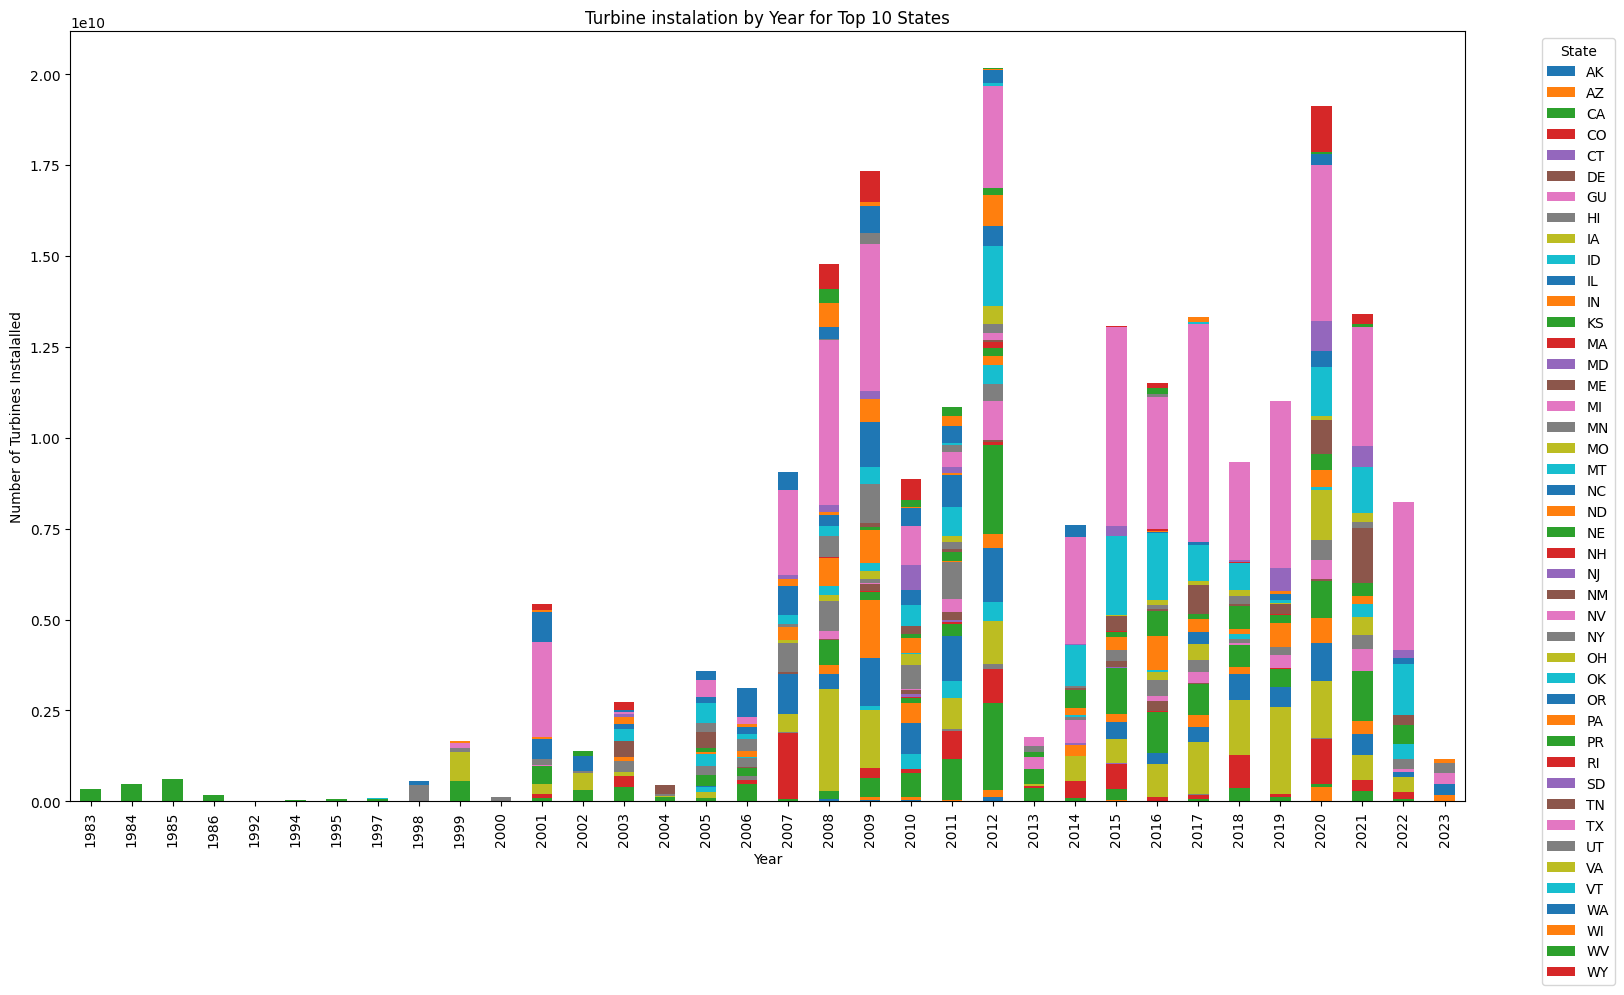

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Example policy events and their years
policy_events = {
    1992: 'Energy Policy Act',
    2005: 'Investment Tax Credit for Solar',
    2009: 'American Clean Energy and Security Act passed House',
    2015: 'Renewable Energy Tax Credits Extension',
    2018: 'Tax Credits and Carbon Pricing',
    2020: 'Major Energy Legislation'
}

# Group and sum or count your data as needed
grouped_df = df.groupby(['p_year', 't_state'])['case_id'].sum().unstack()

# Plot the data as a stacked bar chart
ax = grouped_df.plot(kind='bar', stacked=True, figsize=(18, 10))
plt.title('Turbine instalation by Year for Top 10 States')
plt.xlabel('Year')
plt.ylabel('Number of Turbines Instalalled')

# Place the legend outside the plot area
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Draw vertical lines for policy events
for year, event in policy_events.items():
    plt.axvline(x=year - 0.5, color='red', linestyle='--', alpha=0.7)  # Offset by 0.5 to align with the center of the bar

# Add policy event labels as ticks on the top of the plot
plt.xticks(policy_events.keys(), policy_events.values(), rotation=90, ha='right')
for year, event in policy_events.items():
    ax.text(year - 0.5, ax.get_ylim()[1] * 1.01, event, rotation=90, color='blue', ha='center')

# Adjust the plot to make sure everything fits
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show the plot
plt.show()


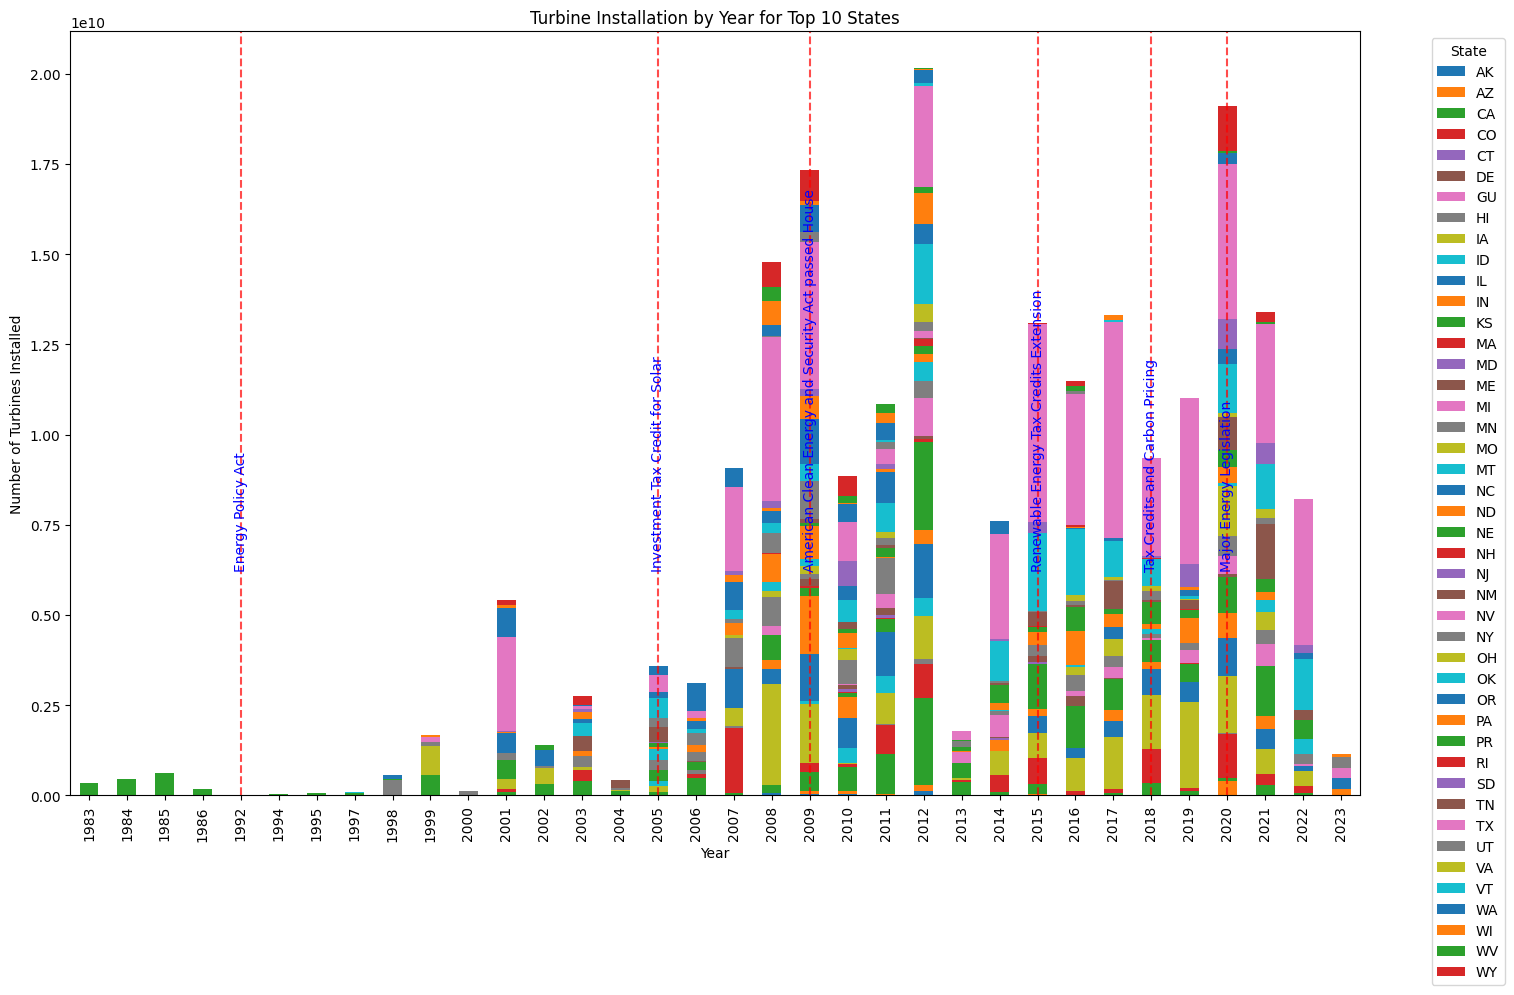

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and it includes 'p_year', 't_state', and 'case_id'

# Example policy events and their years
policy_events = {
    1992: 'Energy Policy Act',
    2005: 'Investment Tax Credit for Solar',
    2009: 'American Clean Energy and Security Act passed House',
    2015: 'Renewable Energy Tax Credits Extension',
    2018: 'Tax Credits and Carbon Pricing',
    2020: 'Major Energy Legislation'
}

# Group and sum your data as needed
grouped_df = df.groupby(['p_year', 't_state'])['case_id'].sum().unstack()

# Plot the data as a stacked bar chart
ax = grouped_df.plot(kind='bar', stacked=True, figsize=(18, 10))
plt.title('Turbine Installation by Year for Top 10 States')
plt.xlabel('Year')
plt.ylabel('Number of Turbines Installed')

# Place the legend outside the plot area
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Draw vertical lines for policy events
for year, event in policy_events.items():
    if year in grouped_df.index:  # Check if the year is in the index
        pos = grouped_df.index.get_loc(year)
        plt.axvline(x=pos, color='red', linestyle='--', alpha=0.7)
        y_pos = grouped_df.max().max() * 1.05  # Slightly above the highest bar
        plt.text(pos, y_pos, event, rotation=90, color='blue', ha='center')

# Adjust the plot to make sure everything fits
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show the plot
plt.show()


<bound method Axes.set of <Axes: title={'center': 'Turbine Installation by Year for Top 10 States'}, xlabel='p_year'>>

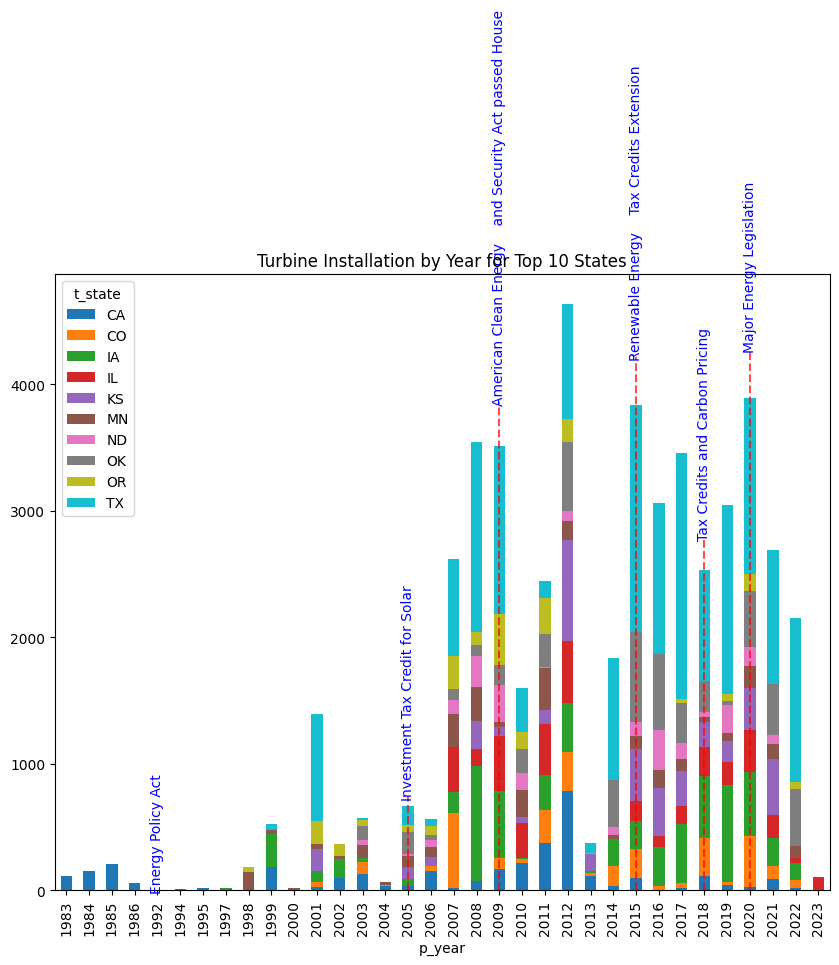

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is pre-loaded with your data and includes 'p_year' for year and 't_state' for state

# Define your policy events
policy_events = {
    1992: 'Energy Policy Act',
    2005: 'Investment Tax Credit for Solar',
    2009: 'American Clean Energy\
    and Security Act passed House',
    2015: 'Renewable Energy\
    Tax Credits Extension',
    2018: 'Tax Credits and Carbon Pricing',
    2020: 'Major Energy Legislation'
}

# Filter the DataFrame to include only the top 10 states by the number of turbines installed
top_states = df['t_state'].value_counts().nlargest(10).index
top_df = df[df['t_state'].isin(top_states)]

# Group and count the number of turbines installed by year and state
grouped_df = top_df.groupby(['p_year', 't_state'])['case_id'].count().unstack(fill_value=0)

# Plot the data as a stacked bar chart
fig, ax = plt.subplots(figsize=(10, 8))
grouped_df.plot(kind='bar', stacked=True, ax=ax)
for year, event in policy_events.items():
    if year in grouped_df.index:  # Check if the year is in the index
        pos = grouped_df.index.get_loc(year)
        # Find the top of the bar for the current year
        bar_height = grouped_df.loc[year].sum()
        # Draw a line that extends 1 inch above the bar in plot units
        # Here we assume the bar height plus 10% is approximately an inch above the bar
        line_height = bar_height + (bar_height * 0.1)
        plt.axvline(x=pos, ymin=0, ymax=line_height/ax.get_ylim()[1], color='red', linestyle='--', alpha=0.7)
        plt.text(pos, line_height, event, rotation=90, color='blue', ha='center', fontsize=10)


# Set the title and labels
ax.set_title('Turbine Installation by Year for Top 10 States')
ax.set

In [111]:
# Import the necessary libraries
import pandas as pd
import plotly.express as px

# Group and sum or count your data as needed
grouped_df = df.groupby(['t_manu', 't_state'])['t_cap'].sum().unstack()
# Convert 't_manu' to a categorical type
df['t_manu'] = df['t_manu'].astype('category')
# Create a bar chart of the top 10 states by turbine capacity
fig = px.bar(df, x='t_state', y='t_cap', color='t_manu',
             title='Turbine Capacity by Manufacturer for Top 10 States')

# Show the plot
fig.show()

<ipython-input-111-c09668da985c>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



TypeError: bar() got multiple values for argument 'x'

In [112]:
# Import the necessary libraries
import pandas as pd
import plotly.express as px

# Assume df is your original DataFrame and it's already defined

# Group and sum or count your data as needed
grouped_df = df.groupby(['t_manu', 't_state'])['t_cap'].sum().reset_index()

# Convert 't_manu' to a categorical type for better plotting
grouped_df['t_manu'] = grouped_df['t_manu'].astype('category')

# Create a bar chart of the top 10 states by turbine capacity
# Assuming 't_state' and 't_cap' are the names of the state and capacity columns in grouped_df
fig = px.bar(grouped_df, x='t_state', y='t_cap', color='t_manu',
             title='Turbine Capacity by Manufacturer for Top 10 States')

# Show the plot
fig.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



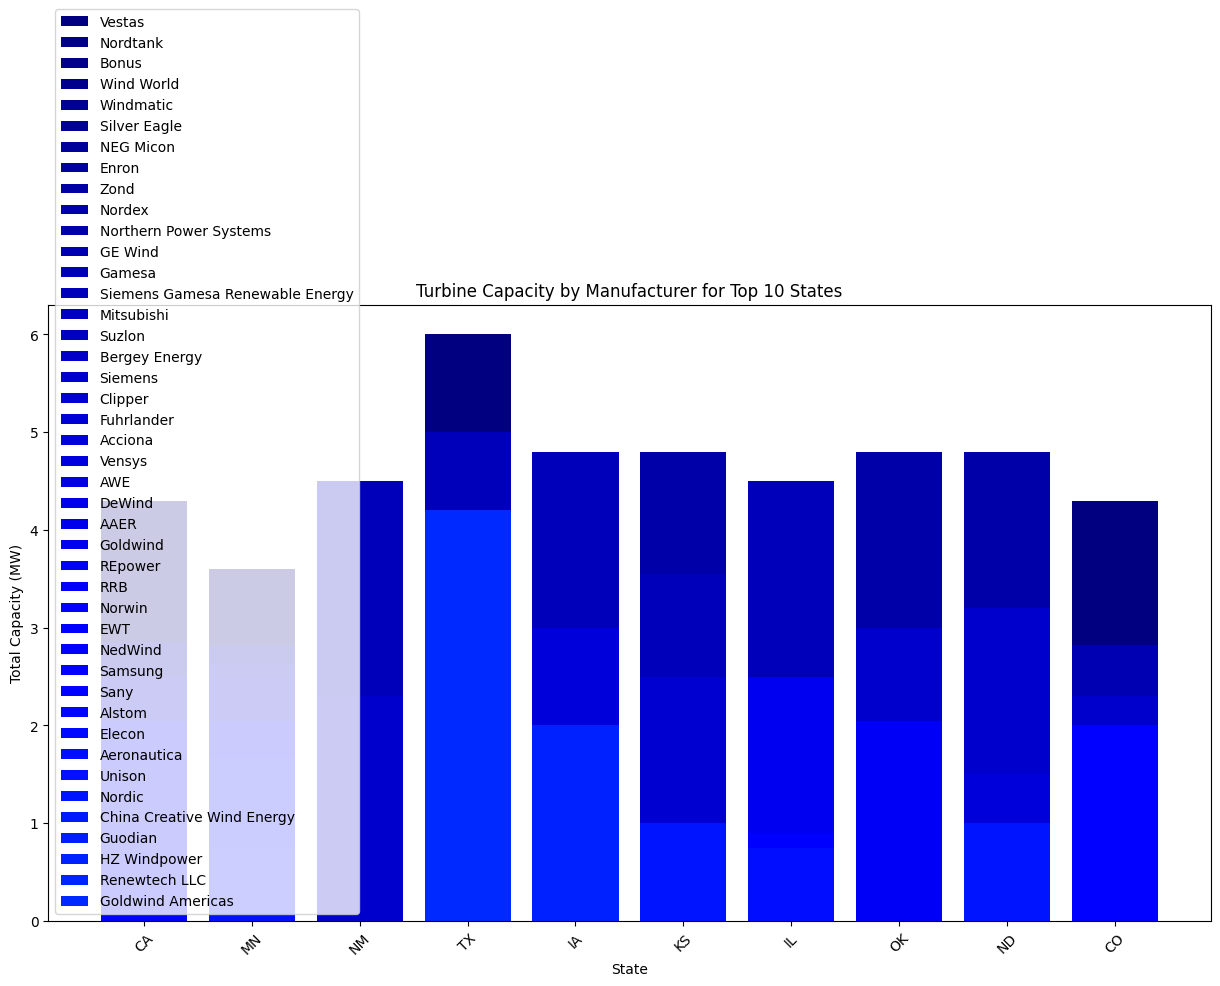

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and contains 't_manu', 't_state', and 't_cap'

# Filter for the top 10 states by turbine capacity
top_states = df.groupby('t_state')['t_cap'].sum().nlargest(10).index
df_top = df[df['t_state'].isin(top_states)]

# Create a color map for manufacturers
unique_manufacturers = df_top['t_manu'].unique()
colors = plt.cm.jet(range(len(unique_manufacturers)))
color_map = dict(zip(unique_manufacturers, colors))

# Create the bar chart
plt.figure(figsize=(15, 8))
for manufacturer in unique_manufacturers:
    # Filter the DataFrame for each manufacturer
    manu_df = df_top[df_top['t_manu'] == manufacturer]
    plt.bar(manu_df['t_state'], manu_df['t_cap'], color=color_map[manufacturer], label=manufacturer)

# Add labels and title
plt.xlabel('State')
plt.ylabel('Total Capacity (MW)')
plt.title('Turbine Capacity by Manufacturer for Top 10 States')
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
!pip install plotly


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



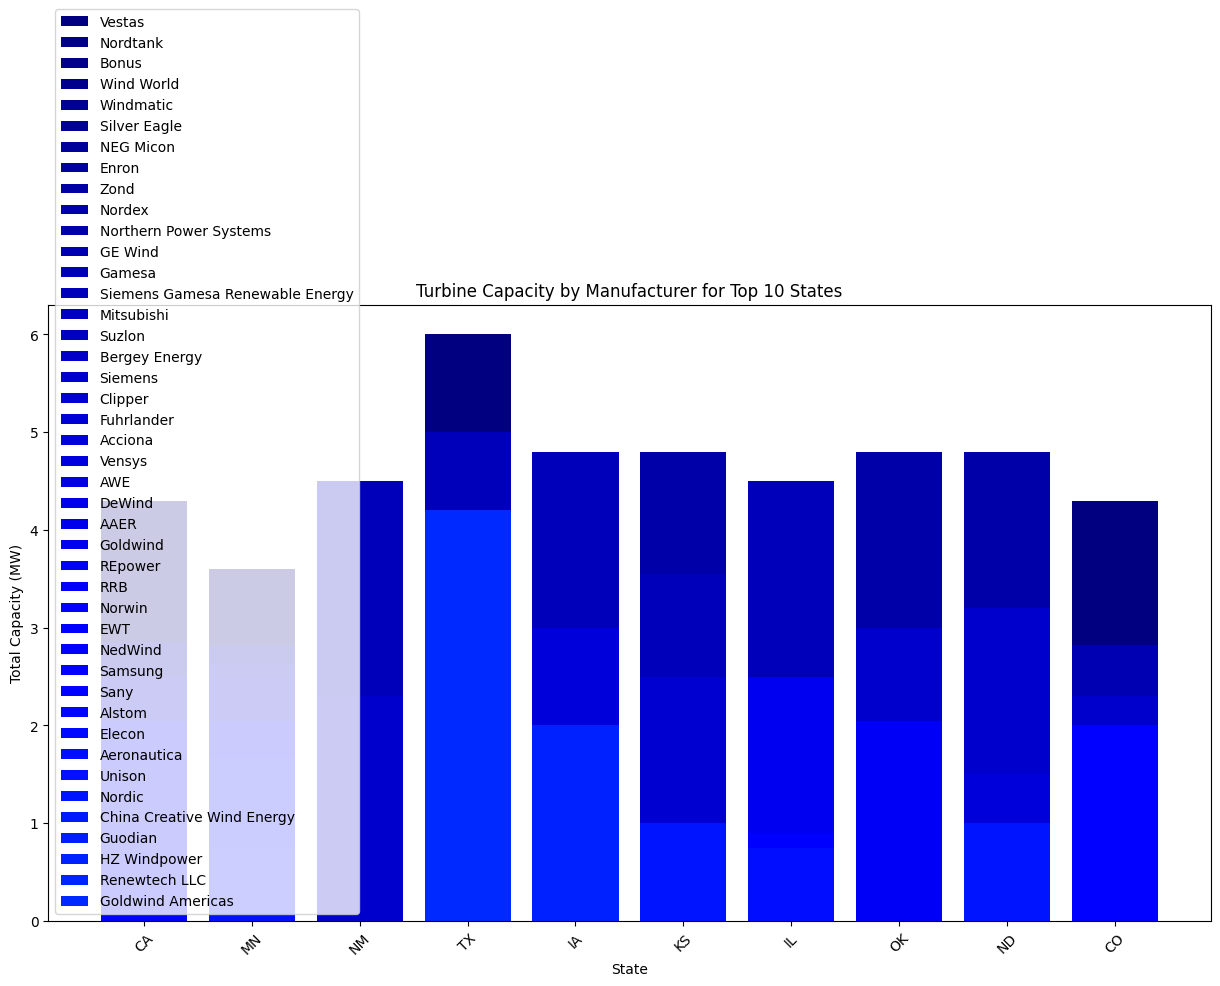

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame and contains 't_manu', 't_state', and 't_cap'

# Filter for the top 10 states by turbine capacity
top_states = df.groupby('t_state')['t_cap'].sum().nlargest(10).index
df_top = df[df['t_state'].isin(top_states)]

# Create a color map for manufacturers
unique_manufacturers = df_top['t_manu'].unique()
colors = plt.cm.jet(range(len(unique_manufacturers)))
color_map = dict(zip(unique_manufacturers, colors))

# Create the bar chart
plt.figure(figsize=(15, 8))
for manufacturer in unique_manufacturers:
    # Filter the DataFrame for each manufacturer
    manu_df = df_top[df_top['t_manu'] == manufacturer]
    plt.bar(manu_df['t_state'], manu_df['t_cap'], color=color_map[manufacturer], label=manufacturer)

# Add labels and title
plt.xlabel('State')
plt.ylabel('Total Capacity (MW)')
plt.title('Turbine Capacity by Manufacturer for Top 10 States')
plt.xticks(rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [119]:
# prompt: change the file to csv

df.to_csv('chadi_data.csv', index=False)
